# <font color="darkred">  Classification of Chest X-ray to detect Covid-19
 <br>
<br>

_20210382_       오정욱 <br>
_20226410_ Alexia Mallet

## <font color='burlywood'> Acknowledgment

This project has for objective to reproduce the network and results of COV19‑ResNet: Diagnostic Inference Engines for Early Detection of COVID‑19 -  Ayturk Keles, Mustafa Berk Keles, Ali Keles - (https://link.springer.com/content/pdf/10.1007/s12559-020-09795-5.pdf)

The Dataset used is called __COVIDx CXR-3__ and was downloaded from https://www.kaggle.com/datasets/andyczhao/covidx-cxr2?select=competition_test. <br> 
The credits for data collection belongs to _Wang, Linda and Lin, Zhong Qiu and Wong, Alexander, COVID-Net: a tailored deep convolutional neural network design for detection of COVID-19 cases from chest X-ray images, Scientific Reports, 2020_


_To access the desired part of the code, clic on the name in the Table of contents_

## <font color='burlywood'> Table of contents
* I. [<font color='black'> Set up ](#paragraph1)
    * I.1. [<font color='dimgray'> Library importation](#subparagraph11)
    * I.2. [<font color='dimgray'> Configuration and Hyper-parameters](#subparagraph12)
    * I.3. [<font color='dimgray'> Data importation](#subparagraph13)     
* II. [<font color='black'> Network implementation](#paragraph2)
    * II.1. [<font color='dimgray'> Implementation of Conv Block](#subparagraph21)
    * II.2. [<font color='dimgray'> Implementation of Identity Block](#subparagraph22)
    * II.3. [<font color='dimgray'> Implementation of ResNet Block](#subparagraph23)
    * II.4. [<font color='dimgray'> Implementation of the network COV19ResNet](#subparagraph24)
* III. [<font color='black'> Training the network](#paragraph3)
    * III.1. [<font color='dimgray'> Settings](#subparagraph31)
    * III.2. [<font color='dimgray'> Training](#subparagraph32)
    * III.3. [<font color='dimgray'> Inference](#subparagraph33)
    * III.4. [<font color='dimgray'> Results](#subparagraph34)

<a name="paragraph1"></a>
## <font color='burlywood'> I. Set up

<a name="subparagraph11"></a>
###  <font color='sienna'> I.1 -Library importation

In [29]:
# pip install torch ## To run the first time of using it in Jupyter notebook 

In [30]:
# pip install torchvision ## To run the first time of using it in Jupyter notebook 

In [31]:
from PIL import Image
from tqdm import tqdm
from pathlib import Path
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision

from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

import pandas as pd # Read the files for labels 

<a name="subparagraph12"></a>
###  <font color='sienna'> I.2 - Configuration and Hyper-parameters

In [32]:
# pip install easydict ## To run if using it for the first time in Jupyter notebook 

In [33]:
from easydict import EasyDict as edict

# set.seed(1314)
# set manual seeds 
torch.manual_seed(134)
torch.cuda.manual_seed(134)

args = edict()

# basic options 
args.name = 'main'                   # experiment name.
args.ckpt_dir = 'ckpts'              # checkpoint directory name.
args.ckpt_iter = 1000                # how frequently checkpoints are saved.
args.ckpt_reload = 'best'            # which checkpoint to re-load.
args.gpu = True                      # whether or not to use gpu. 

# network options
args.num_filters = 1                # number of output channels in the first nn.Conv2d module in MyNetwork.

# data options
args.batch_size = 128                # number of mini-batch size.

# training options
args.lr = 0.005                        # learning rate.
args.epoch = 30                     # training epoch.

# tensorboard options
args.tensorboard = True              # whether or not to use tensorboard logging.
args.log_dir = 'logs'                # to which tensorboard logs will be saved.
args.log_iter = 100                  # how frequently logs are saved.

<a name="subparagraph13"></a>
###  <font color='sienna'> I.3 -Data importation

Data consists of : 
- A training set composed of 29,979 Chest X-Ray images with names and a txt document with the patient id, the name of the image corresponding, the label (positive (15,994) or negative (13,992)) and the data source 
- A test set composed of 400 Chest X-Ray images with names and a txt document with the patient id, the name of the image corresponding, the label (positive (200) or negative (200)) and the data source 

In the current directory, the following files should be present : <br> 
- Folder __train_image__ : Contains the training images 
- Folder __test_image__ : Contains the testing images 
- Csv file __train.csv__ : Csv files containing [PatientId, File_Name, Class, Data_Source] for the training images
- Csv file __test.csv__ : Csv files containing [PatientId, File_Name, Class, Data_Source] for the testing images

__Importation of the outputs (labels)__

At first, there was a problem (error corresponding to unsupported files) with reading some images from the training set with the function torchvision.io.read_image. A first analysis of the txt file revealed (see below) that the extensions of the documents weren't the problem. A set of images (85) were problematic and were deleted from the txt file (the update is available on github). As the database is consequent (around 30 000 images), this shouldn't impact the results. 

In [34]:
path_train = 'C:/Users/Alexia85/Documents/KAIST/Cours/CS491/Project/archive/train_V1.txt'
train_labels = pd.read_csv(path_train, sep=" ", header=None)
train_labels.columns=['PatientId', 'File_Name', 'Class', 'Data_Source']

In [35]:
train_labels[train_labels.isnull().any(axis=1)]

,PatientId,File_Name,Class,Data_Source


In [36]:
train_labels_test = train_labels
train_labels_test['Extension'] = train_labels_test['File_Name'].str[-4:]

In [37]:
train_labels_test = train_labels_test[(train_labels_test['Extension']!='.png') & (train_labels_test['Extension']!='.jpg')
                                     & (train_labels_test['Extension']!='jpeg')]

In [38]:
train_labels_test # No other extension than png and jpeg. 

,PatientId,File_Name,Class,Data_Source,Extension
18,210,16745_2_1.PNG,negative,cohen,.PNG
396,450,4c8dee3d9fe81567b98ed1b0b2b4c6_jumbo.JPG,negative,cohen,.JPG


These lines were delected : <br>

ANON86 DX.1.2.840.113564.1722810162.20200320112920531100.1203801020003.png negative actmed <br>
ANON162 DX.1.2.840.113564.1722810162.20200320114116138220.1203801020003.png negative actmed <br>
ANON49 DX.1.2.840.113564.1722810162.20200320150341771440.1203801020003.png negative actmed <br>
ANON55 DX.1.2.840.113564.1722810162.20200320155115417540.1203801020003.png negative actmed <br>
ANON213 DX.1.2.840.113564.1722810162.20200320175830093580.1203801020003.png negative actmed <br>
ANON48 DX.1.2.840.113564.1722810162.20200321085646975740.1203801020003.png negative actmed <br>
ANON179 DX.1.2.840.113564.1722810162.20200321114314263800.1203801020003.png negative actmed <br>
ANON207 DX.1.2.840.113564.1722810162.20200321204028829980.1203801020003.png negative actmed <br>
ANON109 DX.1.2.840.113564.1722810162.202003212127446125.1203801020003.png negative actmed <br>
ANON95 DX.1.2.840.113564.1722810162.20200322012248568150.1203801020003.png negative actmed <br>
ANON145 DX.1.2.840.113564.1722810162.20200322143316916570.1203801020003.png negative actmed <br>
ANON173 DX.1.2.840.113564.1722810162.20200323104202808100.1203801020003.png negative actmed <br>
ANON56 DX.1.2.840.113564.1722810162.20200323113158393220.1203801020003.png negative actmed <br>
ANON243 DX.1.2.840.113564.1722810162.20200324140423562310.1203801020003.png negative actmed <br>
ANON17 DX.1.2.840.113564.1722810162.20200324163640450390.1203801020003.png negative actmed <br>
ANON5 DX.1.2.840.113564.1722810162.20200324173713500510.1203801020003.png negative actmed <br>
ANON96 DX.1.2.840.113564.1722810162.202003251249284366.1203801020003.png negative actmed <br>
ANON54 DX.1.2.840.113564.1722810162.20200325130434611240.1203801020003.png negative actmed <br>
ANON97 DX.1.2.840.113564.1722810162.20200325133712872360.1203801020003.png negative actmed <br>
ANON125 DX.1.2.840.113564.1722810162.20200325160609990420.1203801020003.png negative actmed <br>
ANON52 DX.1.2.840.113564.1722810162.20200325180041010540.1203801020003.png negative actmed <br>
ANON229 DX.1.2.840.113564.1722810162.20200325180923403640.1203801020003.png negative actmed <br>
ANON62 DX.1.2.840.113564.1722810162.20200326103306090980.1203801020003.png negative actmed <br>
ANON81 DX.1.2.840.113564.1722810162.20200327115150971770.1203801020003.png negative actmed <br>
ANON182 DX.1.2.840.113564.1722810162.20200327130648390830.1203801020003.png negative actmed <br>
ANON137 DX.1.2.840.113564.1722810162.20200327135950280950.1203801020003.png negative actmed <br>
ANON75 DX.1.2.840.113564.1722810162.20200328130557219720.1203801020003.png negative actmed <br>
ANON166 DX.1.2.840.113564.1722810162.20200330101715842390.1203801020003.png negative actmed <br>
ANON171 DX.1.2.840.113564.1722810162.20200330115928823450.1203801020003.png negative actmed <br>
ANON13 DX.1.2.840.113564.1722810162.20200330142125620570.1203801020003.png negative actmed <br>
ANON11 DX.1.2.840.113564.1722810162.20200330155549529100.1203801020003.png negative actmed <br>
ANON163 DX.1.2.840.113564.1722810162.20200331093347514180.1203801020003.png negative actmed <br>
ANON35 DX.1.2.840.113564.1722810162.20200331165352707460.1203801020003.png negative actmed <br>
ANON198 DX.1.2.840.113564.1722810162.20200331235358718640.1203801020003.png negative actmed<br>
ANON71 DX.1.2.840.113564.1722810162.20200401095800552100.1203801020003.png negative actmed <br>
ANON183 DX.1.2.840.113564.1722810162.20200403103712240360.1203801020003.png negative actmed <br>
ANON60 DX.1.2.840.113564.1722810162.20200403105318208480.1203801020003.png negative actmed <br>
ANON206 DX.1.2.840.113564.1722810162.20200403113227763540.1203801020003.png negative actmed <br>
ANON35 DX.1.2.840.113564.1722810162.20200404145807490420.1203801020003.png negative actmed <br>
ANON10 DX.1.2.840.113564.1722810162.20200404194854145480.1203801020003.png negative actmed <br>
ANON59 DX.1.2.840.113564.1722810162.20200404203720370540.1203801020003.png negative actmed <br>
ANON18 DX.1.2.840.113564.1722810162.20200404210401196600.1203801020003.png negative actmed <br>
ANON242 DX.1.2.840.113564.1722810162.20200405000323941660.1203801020003.png negative actmed <br>
ANON206 DX.1.2.840.113564.1722810162.20200405214257011250.1203801020003.png negative actmed <br>
ANON105 DX.1.2.840.113564.1722810162.20200406082745416370.1203801020003.png negative actmed <br>
ANON221 DX.1.2.840.113564.1722810162.20200406152138599630.1203801020003.png negative actmed <br>
ANON238 DX.1.2.840.113564.1722810162.20200407095712184770.1203801020003.png negative actmed <br>
ANON90 DX.1.2.840.113564.1722810162.20200407110159061830.1203801020003.png negative actmed <br>
ANON165 DX.1.2.840.113564.1722810162.20200407154351156930.1203801020003.png negative actmed <br>
ANON43 DX.1.2.840.113564.1722810162.20200408152416905270.1203801020003.png negative actmed <br>
ANON60 DX.1.2.840.113564.1722810162.20200408170334886370.1203801020003.png negative actmed <br>
ANON190 DX.1.2.840.113564.1722810162.20200409100734996750.1203801020003.png negative actmed <br>
ANON140 DX.1.2.840.113564.1722810162.20200409131002213950.1203801020003.png negative actmed <br>
ANON124 DX.1.2.840.113564.1722810162.20200410122807096300.1203801020003.png negative actmed <br>
ANON59 DX.1.2.840.113564.1722810162.20200410172247966360.1203801020003.png negative actmed <br>
ANON113 DX.1.2.840.113564.1722810162.20200410175512031420.1203801020003.png negative actmed <br>
ANON146 DX.1.2.840.113564.1722810162.20200413144300534160.1203801020003.png negative actmed <br>
ANON20 DX.1.2.840.113564.1722810162.20200413163143169320.1203801020003.png negative actmed <br>
ANON12 DX.1.2.840.113564.1722810162.20200414101717389720.1203801020003.png negative actmed <br>
ANON37 DX.1.2.840.113564.1722810162.20200414150507492960.1203801020003.png negative actmed <br>
ANON205 DX.1.2.840.113564.1722810162.202004141559081673.1203801020003.png negative actmed <br>
ANON208 DX.1.2.840.113564.1722810162.20200414192734848390.1203801020003.png negative actmed <br>
ANON79 DX.1.2.840.113564.1722810162.20200414235332189450.1203801020003.png negative actmed <br>
ANON74 DX.1.2.840.113564.1722810162.20200415172911278870.1203801020003.png negative actmed <br>
ANON129 DX.1.2.840.113564.1722810162.20200416083007099140.1203801020003.png negative actmed <br>
ANON130 DX.1.2.840.113564.1722810162.20200416130101712300.1203801020003.png negative actmed <br>
ANON21 DX.1.2.840.113564.1722810162.20200416135234642360.1203801020003.png negative actmed <br>
ANON51 DX.1.2.840.113564.1722810162.20200416190453105480.1203801020003.png negative actmed <br>
ANON161 DX.1.2.840.113564.1722810162.20200416191632203540.1203801020003.png negative actmed <br>
ANON104 DX.1.2.840.113564.1722810162.20200417024634079600.1203801020003.png negative actmed <br>
ANON228 DX.1.2.840.113564.1722810162.20200417102240621720.1203801020003.png negative actmed <br>
ANON149 DX.1.2.840.113564.1722810162.20200417105359936840.1203801020003.png negative actmed <br>
ANON151 DX.1.2.840.113564.1722810162.20200417110000959900.1203801020003.png negative actmed<br>
ANON122 DX.1.2.840.113564.1722810162.202004171314057425.1203801020003.png negative actmed <br>
ANON185 DX.1.2.840.113564.1722810162.20200417134736990110.1203801020003.png negative actmed <br>
ANON180 DX.1.2.840.113564.1722810162.20200417201319616230.1203801020003.png negative actmed <br>
ANON115 DX.1.2.840.113564.1722810162.20200417214150749290.1203801020003.png negative actmed <br>
ANON154 DX.1.2.840.113564.1722810162.20200418123953240490.1203801020003.png negative actmed <br>
ANON98 DX.1.2.840.113564.1722810162.20200418170644187730.1203801020003.png negative actmed <br>
ANON118 DX.1.2.840.113564.1722810162.20200419111851705930.1203801020003.png negative actmed <br>
ANON233 DX.1.2.840.113564.1722810162.20200420123349689300.1203801020003.png negative actmed <br>
ANON192 DX.1.2.840.113564.1722810162.20200420140206725640.1203801020003.png negative actmed <br>
ANON187 DX.1.2.840.113564.1722810162.20200420150441592700.1203801020003.png negative actmed <br>
ANON33 DX.1.2.840.113564.1722810162.20200420155936364760.1203801020003.png negative actmed <br>
ANON41 DX.1.2.840.113564.1722810162.20200420164750991860.1203801020003.png negative actmed <br>

ANON199 DX.1.2.840.113564.1722810162.202003241226081857.1203801020003.png positive actmed <br>
ANON14 DX.1.2.840.113564.1722810162.20200325102716421950.1203801020003.png positive actmed <br>
ANON80 DX.1.2.840.113564.1722810162.20200325125743092120.1203801020003.png positive actmed <br>
ANON60 DX.1.2.840.113564.1722810162.20200326123403551130.1203801020003.png positive actmed <br>
ANON60 DX.1.2.840.113564.1722810162.20200326123552855170.1203801020003.png positive actmed <br>
ANON202 DX.1.2.840.113564.1722810162.20200331100140006240.1203801020003.png positive actmed <br>
ANON136 DX.1.2.840.113564.1722810162.20200405112431725920.1203801020003.png positive actmed <br>

In [39]:
# path_train = 'C:/Users/Alexia85/Documents/KAIST/Cours/CS491/Project/archive/train.txt'
# train.txt is the updated txt file without the images that computed an error when reading them 
path_train = 'C:/Users/Alexia85/Documents/KAIST/Cours/CS491/Project/archive/train.txt'
train_labels = pd.read_csv(path_train, sep=" ", header=None)
train_labels.columns=['PatientId', 'File_Name', 'Class', 'Data_Source'] # Given in the data description 
train_labels=train_labels.drop(['PatientId', 'Data_Source'], axis=1 ) # Don't need the id of the patient or the data source 
# We want an output of 1 for postive and 0 for negative 
def binary_transform(var) : 
    if(var == 'positive') : 
        return (1)
    else : 
        return(0)
train_labels['Class'] = train_labels['Class'].apply(binary_transform)

path_test = 'C:/Users/Alexia85/Documents/KAIST/Cours/CS491/Project/archive/test.txt'
test_labels = pd.read_csv(path_test, sep=" ", header=None)
test_labels.columns=['PatientId', 'File_Name', 'Class', 'Data_Source'] # Given in the data description 
test_labels=test_labels.drop(['PatientId', 'Data_Source'], axis=1 ) # Don't need the id of the patient or the data source 
# We want an output of 1 for postive and 0 for negative 
test_labels['Class'] = test_labels['Class'].apply(binary_transform)


In [40]:
train_labels.head()

,File_Name,Class
0,ARDSSevere.png,0
1,acute-respiratory-distress-syndrome-ards-1.jpg,0
2,acute-respiratory-distress-syndrome-ards.jpg,0
3,ards-secondary-to-tiger-snake-bite.png,0
4,pneumocystis-pneumonia-2-PA.png,0


In [41]:
train_labels['Class'].value_counts()

1    15987
0    13907
Name: Class, dtype: int64

In [42]:
train_labels.shape

(29894, 2)

__Importation of the images and creation of iterable objects__

In [43]:
# from skimage import io, transform
# Function allowing to read an image thanks to the path 
def import_image(name, train = True) : 
    # Inputs : 
    # name : file name for the image (it is from the csv file)
    # train : Boolean, if true, we look for an image in the training set, otherwise, we look for an image in the testing set
    # Output : 
    # Reads the selected image
    if (train) : 
        path_train = "C:/Users/Alexia85/Documents/KAIST/Cours/CS491/Project/archive/train_image/"
        return (torchvision.io.read_image(path_train + name))
    else : 
        path_test = "C:/Users/Alexia85/Documents/KAIST/Cours/CS491/Project/archive/test_image/"
        return (torchvision.io.read_image(path_test + name))

In [44]:
# Customized dataset importation (function already implemented for CIFAR10 database for instance)
# It is composed of three functions: init, len and getitem
# It inherites from Dataset
import torchvision.transforms.functional as F
class ImportData(Dataset):
    def __init__(self, df, train_bool = True):
        # Inputs : 
        # df : DataFrame from the csv file with the names of the images and the corresponding class 
        # train_bool: if True, importation of the training dataset, otherwise, importation of the testing dataset
        self.df = df 
        self.train = train_bool 

    def __len__(self):
        # Returns the number of rows in the dataset df 
        return self.df.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # Gets the images and labels to be able to construct an iterable object to train later 
        image = import_image(self.df["File_Name"][idx], self.train)
        label = self.df["Class"][idx]

        gt_trans = transforms.Compose([
            transforms.ToPILImage(), # Didn't work without it as some images have a fourth channel (rgb_to_grayscale didn't work)
            transforms.Resize((224, 224)), # From the paper, the image are of size (224 × 224 × 1)
            transforms.Grayscale(num_output_channels=1), # Making sure to have grayscale images (1 channel)
            transforms.ToTensor(),
            transforms.Normalize((0.5),(0.5))]) # Added after experiencing gradient exploding during training
        image = gt_trans(image)

        return image, label

In [45]:
train_data = ImportData(train_labels) # Importation of the training dataset 
test_data = ImportData(test_labels, train_bool = False) # Importation of the training dataset 

In [46]:
# Creation of the iterable objects 
train_dataloader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=args.batch_size, shuffle=False, drop_last=False)

<a name="paragraph2"></a>
## <font color='burlywood'> II. Network implementation

In this part, we implement : 
- The Conv Block 
- The Identity Block 
- The ResNet Block composed of the Conv Block and a designated number of Identity Blocks 
- COV_ResNet which is the final network

<a name="subparagraph21"></a>
###  <font color='sienna'> II.1 -Implementation of Conv Block

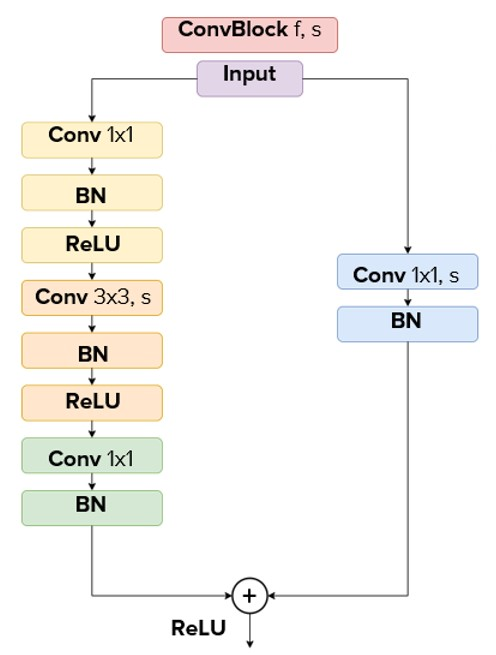

In [47]:
class Conv_Block(nn.Module):
    def __init__(self, in_channels, f, s):
        super(Conv_Block, self).__init__()
        """
        Conv_Block implementation
        
        Args:
            1. in_channels (int) : Number of channels in the input.
            2. f (int): Number of channels in the output.
            3. s (int): stride
        Returns the output of the conv block 
        """
        # Convolution layer 
        self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = f, kernel_size = 1)
        # Batch normalization in 2D 
        self.bn1 = nn.BatchNorm2d(f)
        # ReLU
        self.act1 = nn.ReLU()

        # Convolution layer 
        # Add a padding of 1 otherwise problems in the dimension sizes 
        self.conv2 = nn.Conv2d(in_channels = f, out_channels = f, kernel_size = 3, stride = s, padding = 1)
        # Batch normalization in 2D 
        self.bn2 = nn.BatchNorm2d(f)
        # ReLU
        self.act2 = nn.ReLU()

        # Convolution layer 
        self.conv3 = nn.Conv2d(in_channels = f, out_channels = f, kernel_size = 1) # Is output channels supposed to be 4f ? Doesn't match 
        # Batch normalization in 2D 
        self.bn3 = nn.BatchNorm2d(f)

        # Convolution layer 
        self.conv4 = nn.Conv2d(in_channels = in_channels, out_channels = f, kernel_size = 1, stride = s)
        # Batch normalization in 2D 
        self.bn4 = nn.BatchNorm2d(f)

        # ReLU 
        self.act = nn.ReLU()


    def forward(self, x):
        """
        Feed-forward data 'x' through the module.
                
        Args:
            1. x (torch.FloatTensor)
            .
        Returns:
            1. output (torch.FloatTensor)
        """

        output1 = self.act1(self.bn1(self.conv1(x)))
        output1 = self.act2(self.bn2(self.conv2(output1)))
        output1 = self.bn3(self.conv3(output1))

        output2 = self.bn4(self.conv4(x))

        output = output1 + output2
        output = self.act(output)

        return output

<a name="subparagraph22"></a>
###  <font color='sienna'> II.2 -Implementation of Identity Block

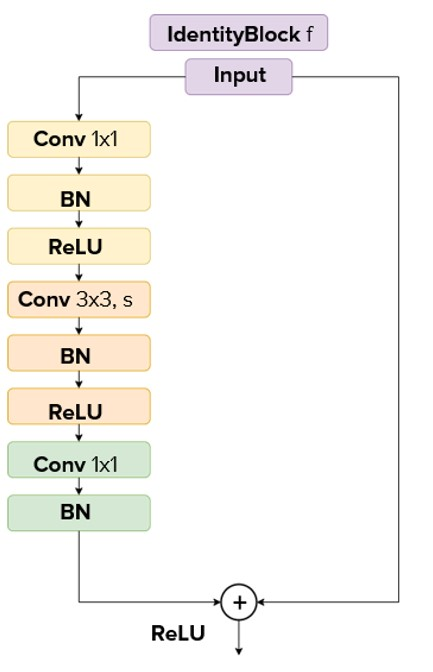

In [48]:
class Identity_Block(nn.Module):
    def __init__(self, in_channels, f):
        super(Identity_Block, self).__init__()
        """
        Identity_Block implementation
        
        Args:
            1. in_channels (int) : Number of channels in the input.
            2. f (int): Number of channels in the output.
        Returns the output of the conv block 
        """
        # Convolution layer 
        self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = f, kernel_size = 1, padding = 'valid')
        # Batch normalization in 2D 
        self.bn1 = nn.BatchNorm2d(f)
        # ReLU
        self.act1 = nn.ReLU()

        # Convolution layer 
        self.conv2 = nn.Conv2d(in_channels = f, out_channels = f, kernel_size = 3, padding = 'same')
        # Batch normalization in 2D 
        self.bn2 = nn.BatchNorm2d(f)
        # ReLU
        self.act2 = nn.ReLU()

        # Convolution layer 
        self.conv3 = nn.Conv2d(in_channels = f, out_channels = f, kernel_size = 1, padding = 'valid')
        # Batch normalization in 2D 
        self.bn3 = nn.BatchNorm2d(f)

        # ReLU 
        self.act = nn.ReLU()


    def forward(self, x):
        """
        Feed-forward data 'x' through the module.
                
        Args:
            1. x (torch.FloatTensor)
            .
        Returns:
            1. output (torch.FloatTensor)
        """

        output = self.act1(self.bn1(self.conv1(x)))
        output = self.act2(self.bn2(self.conv2(output)))
        output = self.bn3(self.conv3(output))

        output = output + x 
        output = self.act(output)
        return output

<a name="subparagraph23"></a>
###  <font color='sienna'> II.3 -Implementation of the ResNet block

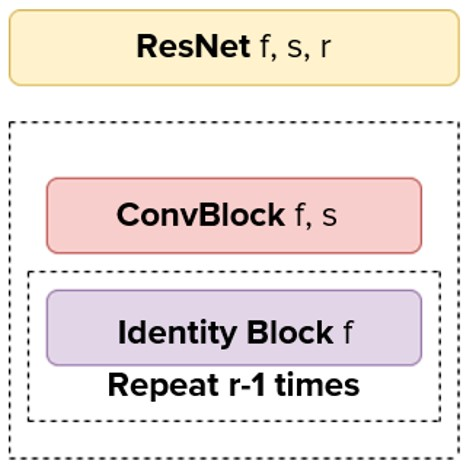

In [49]:
class ResNet_Block(nn.Module):
    def __init__(self,in_channels, f, s, r):
        super(ResNet_Block, self).__init__()
        """
        ResNet_Block implementation
        
        Args:
            1. in_channels (int) : Number of channels in the input.
            2. f (int): Number of channels in the output.
            3. s (int) : stride 
            4. r (int) : Run r-1 times the identity block after the conv block 

        Returns the output of the ResNet block 
        """

        # Conv_Block 
        self.conv_block = nn.Sequential(*[Conv_Block(in_channels, f, s)])
        # Identity_Block 
        self.id_block = nn.Sequential(*[Identity_Block(f, f) for _ in range(r-1)])
       

    def forward(self, x):
        """
        Feed-forward data 'x' through the module.
                
        Args:
            1. x (torch.FloatTensor)
            .
        Returns:
            1. output (torch.FloatTensor)
        """

        output = self.id_block(self.conv_block(x))
        
        return output

<a name="subparagraph24"></a>
###  <font color='sienna'> II.4 -Implementation of the network COV19ResNet

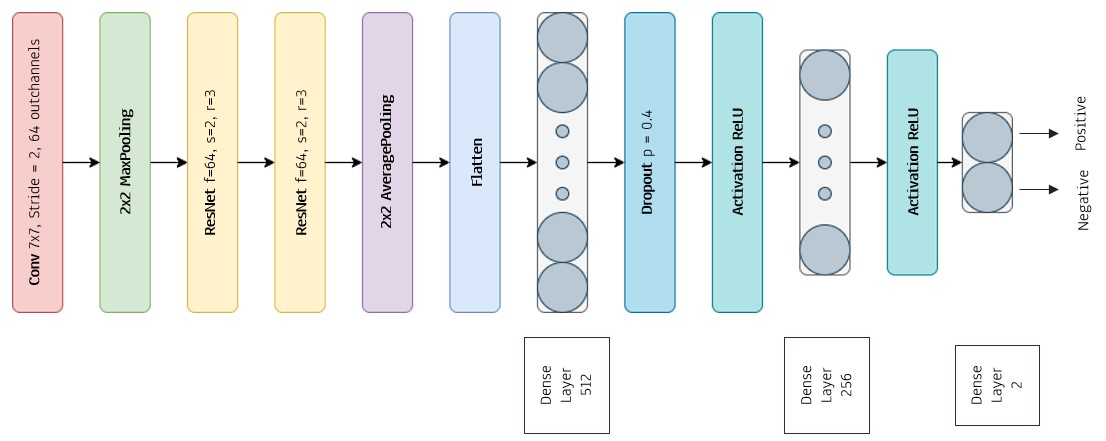

Here, we only output two neurons : Negative (to COVID 19) or Positive (to COVID 19). The detection of viral pneumonia isn't the focus of this project. 

In [50]:
class COV19_ResNet(nn.Module):
    def __init__(self):
        super(COV19_ResNet, self).__init__()
        """
        COV19_ResNet implementation
        
        Args:
            1. in_channels (int) : Number of channels in the input. (Should be 124x124x1)
        Returns the output of the con block 
        """
        # Convolution layer 
        self.res_conv1 = nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 7, stride = 2)
        # MaxPooling layer 
        self.pool1 = nn.MaxPool2d(kernel_size = 2) 
        # First ResNet_Block 
        self.resNet1 = ResNet_Block(in_channels = 64, f=64, s=2, r=3)
        # Second ResNet_Block
        self.resNet2 = ResNet_Block(in_channels = 64, f=128, s=2, r=4)
        # 2x2 Average Pooling 2D 
        self.avg_pool = nn.AvgPool2d(kernel_size = 2)
        # Flatten 
        self.flat = nn.Flatten()
        # Dense unit = 512, dropout 0.4
        # Fully connected layer 
        self.fc1 = nn.Linear(6272, 512) 
        # Dropout 
        self.dropout = nn.Dropout2d(p =0.4)
        # ReLU
        self.act1 = nn.ReLU()
        # Fully connected layer 
        self.fc2 = nn.Linear(512, 256)
        # ReLU
        self.act2 = nn.ReLU()
        # Fully connected layer 
        self.fc3 = nn.Linear(256, 2) # The last layer only has two outputs because we want to identify positive or negative (and not viral pneumonia)
        # Softmax 
        self.softmax = nn.Softmax() 



        


    def forward(self, x):
        """
        Feed-forward data 'x' through the module.
                
        Args:
            1. x (torch.FloatTensor)
            .
        Returns:
            1. output (torch.FloatTensor)
        """
        output = self.res_conv1(x) 
        output = self.pool1(output)
        output = self.avg_pool(self.resNet2(self.resNet1(output)))
        output = self.act1(self.dropout(self.fc1(self.flat(output))))
        output = self.fc3(self.act2(self.fc2(output)))
        # output = self.softmax(output) ## Don't use the softmax because already implemented in the function nn.CrossEntropyLoss()
        
        return output

<a name="paragraph3"></a>
## <font color='burlywood'> III. Training the network

The code in this section was inspired by the code given in the first assignment of class CS491 that this project belongs to. 

<a name="subparagraph31"></a>
###  <font color='sienna'> III.1 - Settings

In [51]:
# Basic settings
device = 'cuda' if torch.cuda.is_available() and args.gpu else 'cpu'

## To change to the path where one wants the results to be saved in 
result_dir = Path('C:/Users/Alexia85/Documents/KAIST/Cours/CS491/Project/results') 
result_dir.mkdir(parents=True, exist_ok=True)

global_step = 0
best_accuracy = 0.

In [52]:
result_dir

WindowsPath('C:/Users/Alexia85/Documents/KAIST/Cours/CS491/Project/results')

In [53]:
# Function to train and test 
def train_net(net, optimizer, scheduler, writer):
    # Inputs : net = network Cov_ResNet
    #          optimizer = the desired optimizer (here Stochastic Gradient Descent)
    #          scheduler = Decays the learning rate of each parameter group by gamma once the number of epoch reaches one of the milestones.
    #          writer = to check progress 
    # Outputs : best_accuracy = accuracy of the best model
    #           test_pred_fin = list of the best model predictions (two values corresponding to each possible outcome for each input)
    #           test_pred_fin = list of the ground truth (0 or 1 for each input)

    
    global_step = 0
    best_accuracy = 0 # Accuracy of the best model 
    test_pred_fin = [] # List of the predictions of the model (tensors with a value for each possible outcome)
    test_truth_fin = [] # Ground truth to compare the results at the end 

    for epoch in range(args.epoch):
        # Train loop.
        net.train()
        for batch_idx, (x, y) in enumerate(train_dataloader):
            # Keep track of the iteration number 
            global_step += 1
            

            #  Send x and y to either cpu or gpu using `device` variable. 
            x = x.to(device=device)
            y = y.to(device=device)
            
            # Feed x into the network, get an output, and keep it in a variable called `logit`. 
            logit = net(x)

            # Compute accuracy of this batch using logit, and keep it in a variable called 'accuracy'.
            accuracy = (logit.argmax(1) == y).float().mean()

            # Compute loss using logit and y, and keep it in a variable called loss.
            loss = nn.CrossEntropyLoss()(logit, y)

            # flush out the previously computed gradient.
            optimizer.zero_grad()

            # backward the computed loss. 
            loss.backward()

            # update the network weights. 
            optimizer.step()

            if global_step % args.log_iter == 0 and writer is not None:
                # Log loss and accuracy values using writer. Use global_step as a timestamp for the log. 
                writer.add_scalar('train_loss', loss, global_step)
                writer.add_scalar('train_accuracy', accuracy, global_step)

            if global_step % args.ckpt_iter == 0: 
                # Save network weights in the directory specified by ckpt_dir directory. 
                torch.save(net.state_dict(), f'{ckpt_dir}/{global_step}.pt')

        # Test loop.
        net.eval()
        with torch.no_grad():
            test_loss = 0.
            test_accuracy = 0.
            test_num_data = 0.
            test_pred = [] # Keep the model prediction
            test_truth = [] # Ground truth 
            for batch_idx, (x, y) in enumerate(test_dataloader):
                # Send x and y to either cpu or gpu using device variable
                x = x.to(device=device)
                y = y.to(device=device)

                # Feed x into the network, get an output, and keep it in a variable called logit.
                logit = net(x)

                # Compute loss using logit and y, and keep it in a variable called loss.
                loss = nn.CrossEntropyLoss()(logit, y)
                
                test_pred.append(logit) # Predictions
                test_truth.append(y) # Ground truth 

                # Compute accuracy of this batch using logit, and keep it in a variable called accuracy.
                accuracy = (logit.argmax(dim=1) == y).float().mean()

                test_loss += loss.item()*x.shape[0] # Additive loss 
                test_accuracy += accuracy.item()*x.shape[0] # Accuracy 
                test_num_data += x.shape[0] # How many images were tested so far 

            test_loss /= test_num_data 
            test_accuracy /= test_num_data

            if writer is not None: 
                # Log loss and accuracy values using writer. Use global_step as a timestamp for the log. 
                writer.add_scalar('test_loss', test_loss, global_step)
                writer.add_scalar('test_accuracy', test_accuracy, global_step)

                # Checking progress (an epoch takes 45 minutes to an hour and 15 minutes to train)
                print(f'Test result of epoch {epoch}/{args.epoch} || loss : {test_loss:.3f} acc : {test_accuracy:.3f} ')

                writer.flush()

            # Whenever test_accuracy is greater than best_accuracy, save network weights with the filename best.pt in the directory specified by ckpt_dir
            if test_accuracy > best_accuracy:
                best_accuracy = test_accuracy # Update of the accuracy 
                test_pred_fin = test_pred # Update of the predictions 
                test_truth_fin = test_truth # Update of the grounf truth (needed because the order of processing is randomized)
                torch.save(net.state_dict(), f'{ckpt_dir}_best.pt') # Save the network weigths
    
        scheduler.step()
    return best_accuracy, test_pred_fin, test_truth_fin


In [54]:
# Function for weight initialization.
def weight_init(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        torch.nn.init.constant_(m.weight, 1)
        torch.nn.init.constant_(m.bias, 0)

In [55]:
# pip install tensorboard ## To run if this is the first time executing it from Jupyter notebook

In [56]:
# Setup tensorboard.
if args.tensorboard:
    from torch.utils.tensorboard import SummaryWriter 
    %load_ext tensorboard
    logs_base_dir = "./logs"
    import datetime, os
    os.makedirs(logs_base_dir, exist_ok=True)
    %tensorboard --logdir {logs_base_dir}
else:
    writer = None

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 26600), started 3 days, 20:54:16 ago. (Use '!kill 26600' to kill it.)

In [27]:
# Create directory name.
num_trial=0
parent_dir = result_dir / f'trial_{num_trial}'
while parent_dir.is_dir():
    num_trial = int(parent_dir.name.replace('trial_',''))
    parent_dir = result_dir / f'trial_{num_trial+1}'
print(f'Logs and ckpts will be saved in : {parent_dir}')



network = COV19_ResNet().to(device)
network.apply(weight_init)


Logs and ckpts will be saved in : C:\Users\Alexia85\Documents\KAIST\Cours\CS491\Project\results\trial_13


COV19_ResNet(
  (res_conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (resNet1): ResNet_Block(
    (conv_block): Sequential(
      (0): Conv_Block(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU()
        (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv4): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2))
        (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU()
      )
    )
    (id_bl

<a name="subparagraph32"></a>
###  <font color='sienna'> III.2 - Training

In [57]:
 # Define optimizer
optimizer = optim.SGD(network.parameters(), lr=args.lr, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15,25], gamma=0.5)
        
# Create directories for logs and ckechpoints.
ckpt_dir = parent_dir / args.name / args.ckpt_dir
ckpt_dir.mkdir(parents=True, exist_ok=True)
log_dir = parent_dir / args.name / args.log_dir
log_dir.mkdir(parents=True, exist_ok=True)

# Create tensorboard writer,
if args.tensorboard: 
    writer = SummaryWriter(log_dir)

# Call the train & test function.
t1 = time.time()
accuracy, test_pred, test_truth = train_net(network, optimizer, scheduler, writer)
t = time.time()-t1
print(f'Best test accuracy : {accuracy:.3f} took {t:.3f} secs')


C:\Users\Alexia85\anaconda3\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Test result of epoch 0/30 || loss : 0.643 acc : 0.667 
Test result of epoch 1/30 || loss : 0.278 acc : 0.892 
Test result of epoch 2/30 || loss : 0.283 acc : 0.902 
Test result of epoch 3/30 || loss : 0.387 acc : 0.865 
Test result of epoch 4/30 || loss : 0.888 acc : 0.642 
Test result of epoch 5/30 || loss : 0.780 acc : 0.743 
Test result of epoch 6/30 || loss : 0.912 acc : 0.695 
Test result of epoch 7/30 || loss : 0.257 acc : 0.910 
Test result of epoch 8/30 || loss : 0.256 acc : 0.930 
Test result of epoch 9/30 || loss : 0.213 acc : 0.955 
Test result of epoch 10/30 || loss : 0.623 acc : 0.853 
Test result of epoch 11/30 || loss : 0.263 acc : 0.950 
Test result of epoch 12/30 || loss : 0.478 acc : 0.890 
Test result of epoch 13/30 || loss : 0.579 acc : 0.865 
Test result of epoch 14/30 || loss : 0.414 acc : 0.907 
Test result of epoch 15/30 || loss : 0.600 acc : 0.887 
Test result of epoch 16/30 || loss : 0.916 acc : 0.848 
Test result of epoch 17/30 || loss : 0.445 acc : 0.935 
Te

<a name="subparagraph33"></a>
###  <font color='sienna'> III.3 - Inference

In [80]:
# Load the model
PATH = './results/trial_12/main/ckpts_best.pt' # Change the name of the directory if needed
model = COV19_ResNet().to(device)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [81]:
def test_only(net) :
    net.eval()
    with torch.no_grad():
        test_loss = 0.
        test_accuracy = 0.
        test_num_data = 0.
        # test_pred = pd.DataFrame(columns = ['Prediction', 'Ground_Truth'])
        test_pred = []
        test_truth = []
        for batch_idx, (x, y) in enumerate(test_dataloader):
            # Send `x` and `y` to either cpu or gpu using `device` variable..
            x = x.to(device=device)
            y = y.to(device=device)

            # Feed `x` into the network, get an output, and keep it in a variable called `logit`.
            logit = net(x)

            # Compute loss using `logit` and `y`, and keep it in a variable called `loss`.
            loss = nn.CrossEntropyLoss()(logit, y)

            # We want to save the predictions in a csv file to be able to compute other metrics (false negative percentage for ex)
            # d_temp = {'Prediction': logit, 'Ground_Truth': y}
            # df_temp = pd.DataFrame(data=d_temp)
            # test_pred = pd.concat([test_pred, df_temp], axis=1)
            test_pred.append(logit)
            test_truth.append(y)

            # Compute accuracy of this batch using `logit`, and keep it in a variable called 'accuracy'.
            accuracy = (logit.argmax(dim=1) == y).float().mean()
            # accuracy = (logit.argmax(dim=1) == y).mean()

            test_loss += loss.item()*x.shape[0]
            test_accuracy += accuracy.item()*x.shape[0]
            test_num_data += x.shape[0]

        test_loss /= test_num_data
        test_accuracy /= test_num_data

    return test_accuracy, test_pred, test_truth

In [82]:
# Call the train & test function.
t1 = time.time()
accuracy, test_pred, test_truth = test_only(model)
t = time.time()-t1
print(f'Best test accuracy : {accuracy:.3f} took {t:.3f} secs')

C:\Users\Alexia85\anaconda3\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Best test accuracy : 0.953 took 56.779 secs


In [83]:
test_pred_copy = test_pred.copy()

In [84]:
test_pred_copy2 = torch.cat(test_pred_copy).detach().cpu().numpy()
test_pred_copy = np.argmax(test_pred_copy2, axis=1)

In [85]:
test_truth_copy = test_truth.copy()
test_truth_copy = torch.cat(test_truth_copy).detach().cpu().numpy()

In [86]:
d_temp = {'Prediction': test_pred_copy, 'Ground_Truth': test_truth_copy}
df_results = pd.DataFrame(data=d_temp)

In [79]:
filepath = Path('./results/trial_12/predictions.csv') 
# df_results.to_csv(filepath, index=False, sep = ';')

<a name="subparagraph34"></a>
###  <font color='sienna'> III.4 - Results

In [300]:
# df_saved_file = pd.read_csv('./results/trial_12/Results_predictions.csv', sep = ';')
# df_results = df_saved_file

__Calcul of the Accuracy__

In [87]:
# Calculate the accuracy again
df_results[df_results.Prediction == df_results.Ground_Truth].shape[0]/ df_results.shape[0]

0.9525

$\text{Accuracy} = \frac{\text{True Positive} + \text{True Negative}}{\text{True Positive} + \text{False Negative} + \text{False Positive} + \text{True Negative}} \times 100$ <br>
$\text{Accuracy} = \text{Sensitivity} \times \text{Prevalence} + \text{Specificity} \times (1 - \text{Prevalence})$ <br>
Where Prevalence is the percentage of positive cases in the data set (here $\text{Prevalence} = 0.5$)

In [88]:
97.5*0.5+99*0.5 # Accuracy of the paper (just given sensitivity and specificity)

98.25

The paper presented an accuracy of 98.25

__Calcul of the sensitivity and specificity__ 

$\text{Sensitivity} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Negative}} \times 100$ <br>
$\text{Specificity} = \frac{\text{True Negative}}{\text{True Negative} + \text{False Positive}} \times 100$

The results of the paper were : <br> 
- Sensitivity = 97.5%
- Specificity = 99% 

In [89]:
# True Positive = number of well diagnosed positive cases 
TP = df_results[(df_results.Prediction == 1) & (df_results.Prediction == df_results.Ground_Truth)].shape[0]
print ('True Positive : ', TP)
# True Negative = number of well diagnosed negative cases
TN = df_results[(df_results.Prediction == 0) & (df_results.Prediction == df_results.Ground_Truth)].shape[0]
print ('True Negative : ', TN)
# False Positive = number of falsly diagnosed positive cases
FP = df_results[(df_results.Prediction == 1) & (df_results.Prediction != df_results.Ground_Truth)].shape[0]
print ('False Positive : ', FP)
# False Negative = number of falsly diagnosed negative cases
FN = df_results[(df_results.Prediction == 0) & (df_results.Prediction != df_results.Ground_Truth)].shape[0]
print ('False Negative : ', FN)

True Positive :  197
True Negative :  184
False Positive :  16
False Negative :  3


The model identify more false positive compared to false negative. 

In [90]:
sensitivity = TP/(TP+FN) * 100 
print ('Sensitivity : ', sensitivity)
specificity = TN/(TN+FP) * 100 
print ('Specificity : ', specificity)

Sensitivity :  98.5
Specificity :  92.0


__Calcul of the Positive Predictive Value (PPV)__ 

$\text{Positive Predictive Value (PPV)} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Positive}} \times 100$ <br>
$\text{Negative Predictive Value (NPV)} = \frac{\text{True Negative}}{\text{True Negative} + \text{False Negative}} \times 100$ 

The results of the paper were : <br> 
- PPV = 99%
- NPV = 97.5%

In [91]:
ppv = TP/(TP+FP) * 100 
print ('PPV : ', ppv)
npv = TN/(TN+FN) * 100 
print ('NPV : ', npv)

PPV :  92.48826291079813
NPV :  98.3957219251337


__Comparison of the levels of confidence for right and wrong answers__

In [92]:
ind_wrong = df_results[df_results.Prediction != df_results.Ground_Truth].index

In [93]:
df_results

,Prediction,Ground_Truth
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
395,0,0
396,0,0
397,0,0
398,0,0


In [94]:
np.sum(np.abs(test_pred_copy2[ind_wrong][:,0] - test_pred_copy2[ind_wrong][:,1]))/test_pred_copy2[ind_wrong].shape[0]

3.4025144075092517

In [95]:
np.sum(np.abs(test_pred_copy2[~ind_wrong][:,0] - test_pred_copy2[~ind_wrong][:,1]))/test_pred_copy2[~ind_wrong].shape[0]

12.842252229389391

The mean of the difference between the two classes is larger for right answers, meaning the model is more certain of the rigth answers. It could be useful to relativize the results with a 'confidence index' calculated thanks to the difference between the value prediction for the two classes. 

Confindence index : we calculate the probability for each prediction 

In [96]:
test_pred_df = pd.DataFrame(test_pred_copy2)
test_pred_df.columns = ['Negatif', 'Positif']
from scipy.special import softmax
test_pred_df = softmax(test_pred_df, axis = 1)

In [97]:
test_pred_df['Max_values'] = test_pred_df[['Negatif','Positif']].max(axis=1)

In [98]:
test_pred_df

,Negatif,Positif,Max_values
0,1.290325e-08,1.000000,1.000000
1,1.263833e-04,0.999874,0.999874
2,1.624995e-06,0.999999,0.999999
3,2.526208e-06,0.999998,0.999998
4,2.349312e-07,1.000000,1.000000
...,...,...,...
395,9.997764e-01,0.000224,0.999776
396,9.993768e-01,0.000623,0.999377
397,7.265410e-01,0.273459,0.726541
398,9.835187e-01,0.016481,0.983519


In [99]:
np.sum(np.abs(test_pred_df.Max_values[ind_wrong]))/test_pred_df.Max_values[ind_wrong].shape[0]

0.8593008141768607

In [100]:
test_pred_df.Max_values[ind_wrong].describe()

count    19.000000
mean      0.859301
std       0.178387
min       0.509991
25%       0.755644
50%       0.966643
75%       0.992562
max       0.999778
Name: Max_values, dtype: float64

In [101]:
ind_right = df_results[df_results.Prediction == df_results.Ground_Truth].index

In [102]:
np.sum(np.abs(test_pred_df.Max_values[ind_right]))/test_pred_df.Max_values[ind_right].shape[0]

0.9731905078637632

In [103]:
test_pred_df.Max_values[ind_right].describe()

count    381.000000
mean       0.973191
std        0.073148
min        0.532325
25%        0.990490
50%        0.999681
75%        0.999995
max        1.000000
Name: Max_values, dtype: float64

Another training with 30 epochs resulted in a slighlty better accuracy (95.5%). The balance between specificty and sensitivity is nearly perfect (sensitivity of 96% and specificity of 95%). Both models seem relevant depending on what we desire from the medical test. If the sensitivity is a priority (could be due to the higlhy infectious factor of the disease), the first model (ckpts_best.pt in the repository) would be prefered. If it is important to have both sensitivity and specificity at the same level, the second model (ckpts_best2.pt) would be prefered. 